In [1]:
using PyPlot
using ODE
using DynamicalSystems
using LinearAlgebra
using PyCall
using Peaks
using NPZ

In [2]:
a1 = 25.04
a2 = 0.23
a3 = 2.25
a4 = 6.82
k0 = -3.7e-3
D = -2.52e-5
beta = 0.0056
Lambd = 4e-5
lambd = 0.08

0.08

In [3]:
@inline @inbounds function loop(u, p, t)
    (a1, a2, a3, a4, k, D, beta, Lambd, lambd) = p
    A = @SMatrix[-beta/Lambd lambd D/Lambd 1/Lambd 0;
     beta/Lambd -lambd 0 0 0;
     a1 0 -a2 0 0;
     0 0 0 0 1;
     0 0 k -a4 -a3]
    (du1, du2, du3, du4, du5) = A * [u[1]; u[2]; u[3]; u[4]; u[5]] + [1/Lambd * u[1] * u[4] + D / Lambd * u[1] * u[3]; 0; 0; 0; 0]
    return SVector{5}(du1, du2, du3, du4, du5)
end

# Jacobian:
@inline @inbounds function loop_jac(u, p, t)
    (a1, a2, a3, a4, k, D, beta, Lambd, lambd) = p
    J = @SMatrix[(-beta/Lambd+1/Lambd*u[4]+D/Lambd * u[3]) lambd (D/Lambd + D/Lambd*u[1]) (1/Lambd+1/Lambd * u[1]) 0;
     beta/Lambd -lambd 0 0 0;
     a1 0 -a2 0 0;
     0 0 0 0 1;
     0 0 k -a4 -a3]
    return J
end

loop_jac (generic function with 1 method)

In [4]:
x0 = [0.1, 0., 0., 0., 0.] # n, c, T, pho_alpha, dot pho_alpha
t = 1000
dt = 0.001
ts = [0:dt:t;]
k_start = 0.9
k_end = 4.0
dk = 0.001
ks = [k_start:dk:k_end;]
ks_len = Int((k_end - k_start) / dk + 1)

trs = zeros(Int(t/dt + 1), ks_len)

Threads.@threads for i = 1:ks_len
    k = ks[i]
    p = [a1, a2, a3, a4, k * k0, D, beta, Lambd, lambd]
    ds = ContinuousDynamicalSystem(loop, x0, p, loop_jac)
    tr = trajectory(ds, t; dt = dt)
    trs[:,i] = tr[:,1]
end

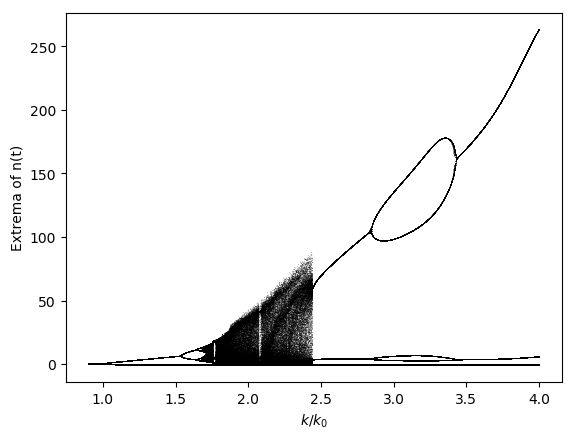

In [5]:
trs_afterTrans = trs[Int((t/dt)/2):end,:];
(m, n) = size(trs_afterTrans)
for i = 1:ks_len
    # find the local minima
    local_minima = findminima(trs_afterTrans[:,i])[2]
    lenth_local_minima = length(local_minima)
    local_maxima = findmaxima(trs_afterTrans[:,i])[2]
    lenth_local_maxima = length(local_maxima)    
    
    PyPlot.scatter(ones(lenth_local_minima)*ks[i], local_minima, marker = ".", edgecolors = "none", s=0.7, color = "black")
    PyPlot.scatter(ones(lenth_local_maxima)*ks[i], local_maxima, marker = ".", edgecolors = "none", s=0.7, color = "black")
end
ylabel("Extrema of n(t)")
xlabel(L"k/k_0")
PyPlot.savefig("extrema_bifurcation_diagram2222222.png",dpi=300)

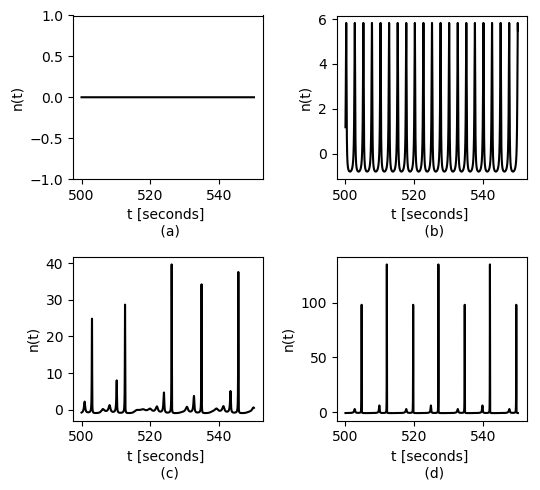

In [6]:
fig, axs = PyPlot.subplots(2, 2, figsize=(5.5, 5.0))
axs[1,1].plot(ts[Int((t/dt)/2):Int((t/dt)/2 + 500000/10)-1,:], trs_afterTrans[1:Int(500000/10), 51], color = "black") # k = 0.95
axs[1,1].set_xlabel("t [seconds] \n (a)")
axs[1,1].set_ylabel("n(t)")
axs[1,1].set_ylim([-1,1])

axs[1,2].plot(ts[Int((t/dt)/2):Int((t/dt)/2 + 500000/10)-1,:], trs_afterTrans[1:Int(500000/10), 601], color = "black") # k = 1.5
axs[1,2].set_xlabel("t [seconds] \n (b)")
axs[1,2].set_ylabel("n(t)")

axs[2,1].plot(ts[Int((t/dt)/2):Int((t/dt)/2 + 500000/10)-1,:], trs_afterTrans[1:Int(500000/10), 1101], color = "black") # k = 2
axs[2,1].set_xlabel("t [seconds] \n (c)")
axs[2,1].set_ylabel("n(t)")

axs[2,2].plot(ts[Int((t/dt)/2):Int((t/dt)/2 + 500000/10)-1,:], trs_afterTrans[1:Int(500000/10), 2101], color = "black") # k = 3
axs[2,2].set_xlabel("t [seconds] \n (d)")
axs[2,2].set_ylabel("n(t)")

fig.tight_layout()
PyPlot.savefig("neutronDensity2222222.png",dpi=300)

In [14]:
println("subplot 1 k/k0: ", ks[51], "\nsubplot 2 k/k0: ", ks[601], "\nsubplot 3 k/k0: ", ks[1101], "\nsubplot 4 k/k0: ", ks[2101])

subplot 1 k/k0: 0.95
subplot 2 k/k0: 1.5
subplot 3 k/k0: 2.0
subplot 4 k/k0: 3.0


In [8]:
npzwrite("BWRn.npy", trs_afterTrans')